In [1]:
# import any libraries you need here
!pip install pandas scikit-learn tensorflow transformers

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

Data format - Prompt, Response, Model in a CSV file

Data loading below

In [3]:
df = pd.read_csv('/content/584 midterm project - Sheet1.csv')
df.head()

,Prompt,Response,Model,Length
0,Yesterday I went,to the beach and watched the sunset.,ChatGPT-4o,36
1,Yesterday I went,for a long walk in the park and cleared my mind.,ChatGPT-4o,48
2,Yesterday I went,shopping for new books and lost track of time.,ChatGPT-4o,46
3,Yesterday I went,to a concert with friends and had an amazing t...,ChatGPT-4o,50
4,Yesterday I went,to the gym and felt energized after my workout.,ChatGPT-4o,47


In [4]:
print(df.columns)

Index(['Prompt', 'Response', 'Model', 'Length'], dtype='object')


In [5]:
# Checking for null vals in dataset
print(df.isnull().sum())

Prompt      0
Response    0
Model       0
Length      0
dtype: int64


In [ ]:
# If null vals present, run this
df.dropna(inplace=True)
# Fill NaN values with empty strings in the 'prompt' and 'response' columns
df['Prompt'].fillna('', inplace=True)
df['Response'].fillna('', inplace=True)


In [6]:
# Combine propt and response into a single feature
df['text'] = df['Prompt'] + " " + df['Response']

# Encode the model names (target variable)
le = LabelEncoder()
df['model_encoded'] = le.fit_transform(df['Model'])

# Features and target var
x = df['text']
y = df['model_encoded']

# Preparing train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Using Logistic Regression for classification

In [7]:
# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform the data
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

In [8]:
# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(x_train_tfidf, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test_tfidf)

In [9]:
# If using logistic regression:
test_acc_lr = accuracy_score(y_test, y_pred)
print("Accuracy:", test_acc_lr)
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.37
              precision    recall  f1-score   support

  ChatGPT-4o       0.32      0.36      0.34        33
      Claude       0.25      0.15      0.18        48
      Cohere       0.66      0.61      0.63        38
     Copilot       0.22      0.14      0.17        44
      Gemini       0.36      0.70      0.47        37

    accuracy                           0.37       200
   macro avg       0.36      0.39      0.36       200
weighted avg       0.35      0.37      0.35       200



Using BERT for classification

In [10]:
# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode text data
x_train_tokens = tokenizer(list(x_train), padding=True, truncation=True, return_tensors='tf', max_length=128)
x_test_tokens = tokenizer(list(x_test), padding=True, truncation=True, return_tensors='tf', max_length=128)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
# Load a pre-trained transformer model for sequence classification
bert_model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Define input tensors and labels for training
train_dataset = tf.data.Dataset.from_tensor_slices((dict(x_train_tokens), y_train)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(x_test_tokens), y_test)).batch(16)

# Compile the model
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

# Train the model
history_bert = bert_model.fit(train_dataset, epochs=15)

# Evaluate on the test set
bert_model.evaluate(test_dataset)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
50/50 [==============================] - 52s 173ms/step - loss: 1.2656 - accuracy: 0.4325
Epoch 2/15
50/50 [==============================] - 8s 168ms/step - loss: 0.7861 - accuracy: 0.6338
Epoch 3/15
50/50 [==============================] - 8s 170ms/step - loss: 0.6171 - accuracy: 0.7212
Epoch 4/15
50/50 [==============================] - 8s 166ms/step - loss: 0.4140 - accuracy: 0.8550
Epoch 5/15
50/50 [==============================] - 9s 173ms/step - loss: 0.2578 - accuracy: 0.9050
Epoch 6/15
50/50 [==============================] - 9s 172ms/step - loss: 0.1956 - accuracy: 0.9375
Epoch 7/15
50/50 [==============================] - 8s 169ms/step - loss: 0.1650 - accuracy: 0.9488
Epoch 8/15
50/50 [==============================] - 9s 171ms/step - loss: 0.1538 - accuracy: 0.9438
Epoch 9/15
50/50 [==============================] - 8s 169ms/step - loss: 0.1344 - accuracy: 0.9538
Epoch 10/15
50/50 [==============================] - 8s 164ms/step - loss: 0.0863 - accuracy: 0.967

[1.019663691520691, 0.7749999761581421]

In [12]:
predictions = bert_model.predict(test_dataset)
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()

# Accuracy and report
test_acc_bert = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {test_acc_bert}")
print(classification_report(y_test, predicted_labels, target_names=le.classes_))

13/13 [==============================] - 4s 73ms/step
Accuracy: 0.775
              precision    recall  f1-score   support

  ChatGPT-4o       0.72      0.79      0.75        33
      Claude       0.80      0.58      0.67        48
      Cohere       0.86      0.95      0.90        38
     Copilot       0.94      0.75      0.84        44
      Gemini       0.62      0.86      0.72        37

    accuracy                           0.78       200
   macro avg       0.79      0.79      0.78       200
weighted avg       0.80      0.78      0.77       200



In [ ]:
# Save transformer model
bert_model.save_pretrained('bert_text_classifier')
tokenizer.save_pretrained('bert_text_classifier')

('bert_text_classifier/tokenizer_config.json',
 'bert_text_classifier/special_tokens_map.json',
 'bert_text_classifier/vocab.txt',
 'bert_text_classifier/added_tokens.json',
 'bert_text_classifier/tokenizer.json')

In [ ]:
# Zipping model to export

!zip -r "/content/text_classifier_model.zip" "/content/bert_text_classifier"

  adding: content/bert_text_classifier/ (stored 0%)
  adding: content/bert_text_classifier/tokenizer_config.json (deflated 76%)
  adding: content/bert_text_classifier/tf_model.h5 (deflated 8%)
  adding: content/bert_text_classifier/vocab.txt (deflated 53%)
  adding: content/bert_text_classifier/config.json (deflated 52%)
  adding: content/bert_text_classifier/special_tokens_map.json (deflated 42%)
  adding: content/bert_text_classifier/tokenizer.json (deflated 71%)


Loading and using model later

In [ ]:
!unzip "/content/bert_text_classifier_model.zip" -d "/bert_text_classifier_2"

Archive:  /content/bert_text_classifier_model.zip
   creating: /bert_text_classifier_2/content/bert_text_classifier/
  inflating: /bert_text_classifier_2/content/bert_text_classifier/tokenizer_config.json  
  inflating: /bert_text_classifier_2/content/bert_text_classifier/tf_model.h5  
  inflating: /bert_text_classifier_2/content/bert_text_classifier/vocab.txt  
  inflating: /bert_text_classifier_2/content/bert_text_classifier/config.json  
  inflating: /bert_text_classifier_2/content/bert_text_classifier/special_tokens_map.json  
  inflating: /bert_text_classifier_2/content/bert_text_classifier/tokenizer.json  


In [ ]:
import numpy as np

# Load transformer model
loaded_bert_model = TFAutoModelForSequenceClassification.from_pretrained('/content/bert_text_classifier_1/content/bert_text_classifier')
loaded_tokenizer = AutoTokenizer.from_pretrained('/content/bert_text_classifier_1/content/bert_text_classifier')

# For new predictions:
new_text = ["I spoke to my friend about a personal challenge I was facing, and their support and advice provided me with a new sense of clarity and direction."]

new_tokens = loaded_tokenizer(new_text, padding=True, truncation=True, return_tensors='tf', max_length=128)
predictions = loaded_bert_model.predict(dict(new_tokens))

# Get the index of the class with the highest logit (predicted class)
predicted_class_idx = np.argmax(predictions.logits, axis=1)

# Decode the predicted class index to get the original label (model name)
predicted_model_name = le.inverse_transform(predicted_class_idx)

print(f"Predicted model: {predicted_model_name[0]}")

Some layers from the model checkpoint at /content/bert_text_classifier_1/content/bert_text_classifier were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/bert_text_classifier_1/content/bert_text_classifier.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further

1/1 [==============================] - 3s 3s/step
Predicted model: Cohere


In [ ]:
print(df.columns)

Index(['Prompt', 'Response', 'Model', 'text', 'model_encoded'], dtype='object')


Preparing and Using LSTMs

In [13]:
#preprocessing data (LSTM)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#df = pd.read_csv('/content/584 midterm project - Sheet1.csv')

# Tokenizing the text (you could also experiment with using char-level tokens)
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')  # Adjust num_words based on dataset size
tokenizer.fit_on_texts(df['text'])

# Convert the texts to sequences of token indices
X_sequences = tokenizer.texts_to_sequences(df['text'])

# Pad sequences to a fixed length (e.g., 100 words per sequence)
X_padded = pad_sequences(X_sequences, maxlen=35, padding='post')
df['model_encoded'] = le.fit_transform(df['Model'])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, df['model_encoded'], test_size=0.2, random_state=42)


In [14]:
# Building the LSTM model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the model architecture
model_lstm = Sequential()

# Modify the Embedding layer
model_lstm.add(Embedding(input_dim=5000, output_dim=128))  # Removed `input_length`


# LSTM layer
model_lstm.add(LSTM(128, return_sequences=False))  # You can also stack LSTMs for more complexity

# Dropout layer to avoid overfitting
model_lstm.add(Dropout(0.3))

# Dense layer for classification
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dropout(0.5))

# Output layer (number of classes)
model_lstm.add(Dense(len(le.classes_), activation='softmax'))

# Compile the model
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model_lstm.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
lstm_history = model_lstm.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2)

# Evaluate the model on test data
test_loss, test_acc_lstm = model_lstm.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc_lstm}')


Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2136 - loss: 1.6098 - val_accuracy: 0.2812 - val_loss: 1.5952
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2576 - loss: 1.5847 - val_accuracy: 0.4250 - val_loss: 1.3055
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4290 - loss: 1.2250 - val_accuracy: 0.5437 - val_loss: 1.0102
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4857 - loss: 1.0261 - val_accuracy: 0.4938 - val_loss: 1.1052
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5342 - loss: 0.9670 - val_accuracy: 0.4938 - val_loss: 0.9872
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6276 - loss: 0.7772 - val_accuracy: 0.4875 - val_loss: 1.0913
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6157 - loss: 0.8206 - val_accuracy: 0.4812 - val_loss: 1.4476
Epoch 8/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5587 - loss: 0.8954 - val_accuracy: 0.531

In [17]:
from sklearn.metrics import classification_report
import numpy as np

# getting individual accuracies for the test set
y_pred = np.argmax(model_lstm.predict(X_test), axis = 1)
print(classification_report(y_test, y_pred, target_names=le.classes_))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
              precision    recall  f1-score   support

  ChatGPT-4o       0.57      0.64      0.60        33
      Claude       0.45      0.52      0.48        48
      Cohere       0.81      0.68      0.74        38
     Copilot       0.47      0.34      0.39        44
      Gemini       0.51      0.59      0.55        37

    accuracy                           0.55       200
   macro avg       0.56      0.56      0.55       200
weighted avg       0.55      0.55      0.54       200



In [ ]:
#saving the lstm model
model_lstm.save('lstm_text_classifier_model.h5')

In [ ]:
#loading and using the lstm model
from tensorflow.keras.models import load_model

# Load the saved LSTM model
loaded_model = load_model('lstm_text_classifier_model.h5')

# Inputing new text into the model
new_text = ["I spoke to my friend about a personal challenge I was facing, and their support and advice provided me with a new sense of clarity and direction."]
new_seq = tokenizer.texts_to_sequences(new_text)
new_padded = pad_sequences(new_seq, maxlen=30, padding='post')

# Use the loaded model to make predictions
predicted_class = loaded_model.predict(new_padded)

# Get the predicted class label (this will be in encoded form)
predicted_label = np.argmax(predicted_class, axis=1)

# Convert the encoded label back to the original model name
predicted_model_name = le.inverse_transform(predicted_label)
print(f"Predicted model: {predicted_model_name[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Predicted model: Cohere


Test Accuracy for Logistic Regression: 37.00%
Test Accuracy for BERT: 77.50%
Test Accuracy for LSTM: 54.50%


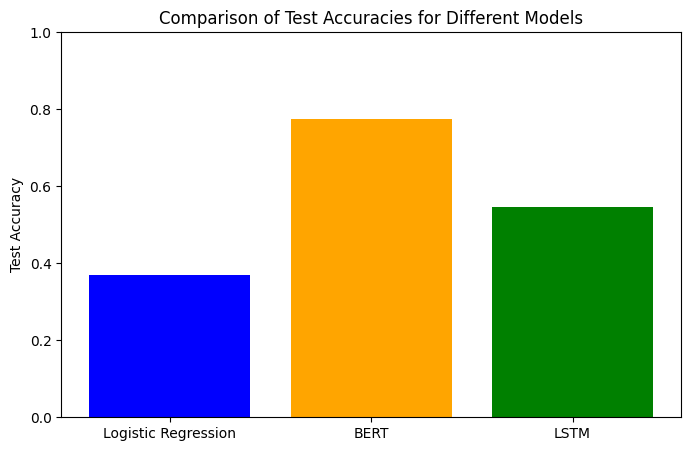

In [18]:
import matplotlib.pyplot as plt

# List of methods and their accuracies
methods = ['Logistic Regression', 'BERT', 'LSTM']
accuracies = [test_acc_lr, test_acc_bert, test_acc_lstm]

# Print the test accuracies for each method
for method, accuracy in zip(methods, accuracies):
    print(f"Test Accuracy for {method}: {accuracy * 100:.2f}%")

# Plot the test accuracies for visual comparison
plt.figure(figsize=(8, 5))
plt.bar(methods, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracies for Different Models')
plt.show()


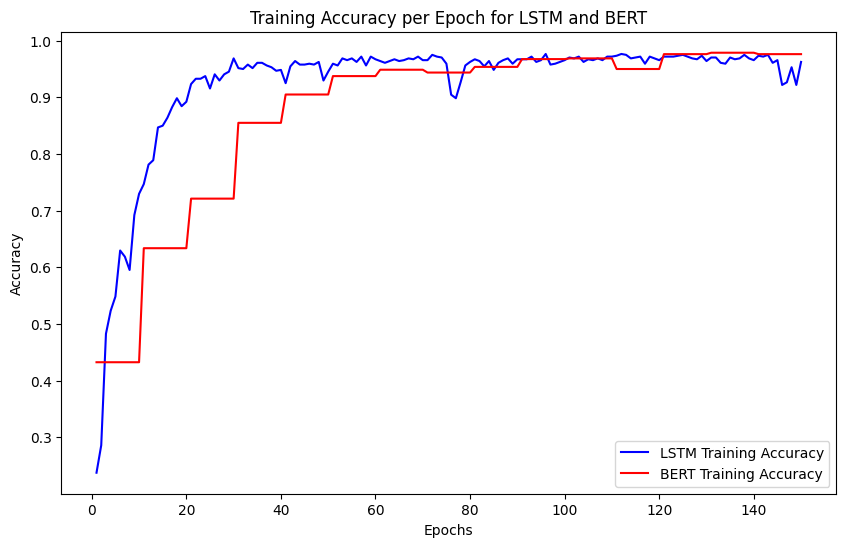

In [19]:
import matplotlib.pyplot as plt

# Retrieve training accuracy for LSTM and BERT from history objects
lstm_acc = lstm_history.history['accuracy']
bert_acc = history_bert.history['accuracy']
bert_acc_scaled = [acc for acc in bert_acc for _ in range(10)]

# Create a line graph for training accuracy over epochs
epochs = range(1, len(lstm_acc) + 1)  # Assuming both models have the same number of epochs

plt.figure(figsize=(10, 6))

# Plot LSTM training accuracy
plt.plot(epochs, lstm_acc, 'b-', label='LSTM Training Accuracy')

# Plot BERT training accuracy
plt.plot(epochs, bert_acc_scaled, 'r-', label='BERT Training Accuracy')

# Adding labels, title, and legend
plt.title('Training Accuracy per Epoch for LSTM and BERT')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()
